# Visualization of Satellite Images

GeoTiff format is different from other image formats.A GeoTIFF is a standard .tif or image file format that includes additional spatial (georeferencing) information embedded in the .tif file as tags. Hence, we need special tags to visualize these files.
By tags, it is meant that it has some additional metadata like Spatial extent, CRS, Resolution, etc. along with the pixel values. It is a popular distribution format for satellite and aerial photography imagery.

### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import numpy as np
import os

# Data dir
data_dir = "../bigearthnet/BigEarthNet-v1.0"

### Sentinel 2 Bands and Combinations

There are 13 Sentinel 2 bands in total. Each band is 10, 20 or 60 meters in pixel size.Sentinel 2 consists of 2 satellites. First came Sentinel 2A which was launched in 2015. Next came Sentinel 2b in 2017.Two additional satellites (Sentinel 2C and 2D) are planned to launch in 2020 and 2021. This will make a total of four Sentinel-2 satellites.
BigEarthNet picks up 13 different bands of EM waves. Three of these bands are visible light - red, green, and blue. These bands can be put together to make a true color image, something that you'd see on Google Earth or something of that sort. The other bands however can be combined in place of the standard red, green, and blue bands to see other interesting things.

BigEarthNet comes with 13 bands . The details of these bands can be found here : https://gisgeography.com/spectral-signature/

- B01: Coastal aerosol or "deep blue and violet" band; **60m**
  This is used to differentiate water from land. It can also see aerosols which are all these little particulates floating around in the air.

- B02: Visible Blue; **10m**
  You can see this with the naked eye.
- B03: Visible Green; **10m**
    You can see this with the naked eye.
- B04: Visible Red; **10m**
    You can see this with the naked eye.
- B05: Vegetation red edge; **20m**
- B06: Vegetation red edge; **20m**
- B07: Vegetation red edge; **20m**
- B08: NIR; **10m**
    This band can be used to study ecological health. Healthy plants will reflect the NIR, so you can get an idea of how healthy they are. From this band, you could also create a Normalized Difference Vegetation Index (NDVI) to study vegetation health.
- B8A: Narrow NIR; **20m**
- B09: Water vapor; **60m**
- B11: SWIR; **20m**
  Will contrast wet and dry earth, as well as soil versus rocks.
- B12: SWIR; **20m**
  Will contrast wet and dry earth, as well as soil versus rocks.

## 1. Display Single band

Full Path of image :  ../bigearthnet/BigEarthNet-v1.0/S2A_MSIL2A_20170701T093031_16_82/S2A_MSIL2A_20170701T093031_16_82_B04.tif
name:  ../bigearthnet/BigEarthNet-v1.0/S2A_MSIL2A_20170701T093031_16_82/S2A_MSIL2A_20170701T093031_16_82_B04.tif
(120, 120)
Bounds:  BoundingBox(left=619200.0, bottom=6900420.0, right=620400.0, top=6901620.0)
Meta Data:  {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 120, 'height': 120, 'count': 1, 'crs': CRS.from_epsg(32635), 'transform': Affine(10.0, 0.0, 619200.0,
       0.0, -10.0, 6901620.0)}
Spacial Resolution:  (10.0, 10.0)
Number of bands:  1
Image Resolution:  120   120
Coordinate reference su=ystem  EPSG:32635


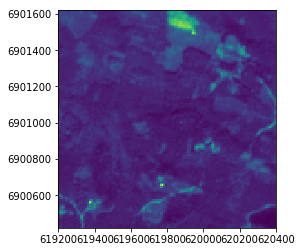

In [4]:
# Data dir
data_dir = "../bigearthnet/BigEarthNet-v1.0"
image_folder="S2A_MSIL2A_20170701T093031_16_82"

# Filepath
fp = os.path.join(data_dir, image_folder,image_folder+"_B04.tif")

print("Full Path of image : " ,fp)
raster = rasterio.open(fp)

#properties 
print("name: ",raster.name)

print(raster.read(1).shape)

#bounds
print("Bounds: " ,raster.bounds)

# general list of attributes
print("Meta Data: " ,raster.meta)

# Spacial Resolution
print("Spacial Resolution: " ,raster.res)

#Number of bands
print("Number of bands: " ,raster.count)

#Image Resolution
print("Image Resolution: " ,raster.height," ",raster.width)

#Coordinate reference su=ystem
print("Coordinate reference su=ystem ",raster.crs)

show(raster)


## 1. Display Multiple bands side by side

Text(0.5, 1.0, 'Blue')

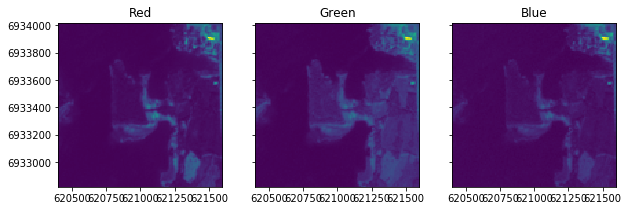

In [9]:
# Initialize subplots
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10, 4), sharey=True)

# Data dir
data_dir = "../bigearthnet/BigEarthNet-v1.0"
image_folder="S2A_MSIL2A_20170701T093031_17_55"

# Filepath
fp2 = os.path.join(data_dir, image_folder,image_folder+"_B02.tif")
fp3 = os.path.join(data_dir, image_folder,image_folder+"_B03.tif")
fp4 = os.path.join(data_dir, image_folder,image_folder+"_B04.tif")

raster2= rasterio.open(fp2)
raster3 = rasterio.open(fp3)
raster4 = rasterio.open(fp4)

# Plot Red, Green and Blue (rgb)
show((raster4), ax=ax1)
show((raster3), ax=ax2)
show((raster2), ax=ax3)

# Add titles
ax1.set_title("Red")
ax2.set_title("Green")
ax3.set_title("Blue")



### Merge Multiple bands into one image


By using band combinations, we can extract specific information from an image. For example, there are band combinations that highlight geologic, agricultural or vegetation features in an image. 

The natural color band combination uses the red (B4), green (B3) and blue (B2) channels. Its purpose is to display imagery the same way our eyes see the world. Just like how we see, healthy vegetation is green. Next, urban features often appear white and grey. Finally, water is a shade of dark blue depending on how clean it is.

I will combine Blue-B02, Green-B03, Red-B04 and NIR-B08 as they are of same resolution(10m).First we need to read the bands into numpy arrays and normalize the cell values into scale ranging from 0.0 to 1.0.Next we need to stack the values from different values together to produce the RGB true color composite. 

In [10]:
# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))


In [44]:
def visualizeGeoData(data_dir,image_folderList,titles=[]):
    # Initialize subplots
    fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 20), sharey=True)

    for index, image_folder in enumerate(image_folderList, start=0):
        print(index, image_folder)
        # Filepath
        fp2 = os.path.join(data_dir, image_folder,image_folder+"_B02.tif")
        fp3 = os.path.join(data_dir, image_folder,image_folder+"_B03.tif")
        fp4 = os.path.join(data_dir, image_folder,image_folder+"_B04.tif")
        fp8 = os.path.join(data_dir, image_folder,image_folder+"_B08.tif")
    
        raster2= rasterio.open(fp2)
        raster3 = rasterio.open(fp3)
        raster4 = rasterio.open(fp4)
        raster8 = rasterio.open(fp8)
        #print("Coordinate reference su=ystem ",raster2.crs)
        # Read the grid values into numpy arrays
        red = raster4.read(1)
        green = raster3.read(1)
        blue = raster2.read(1)
        nir = raster8.read(1)
        # Normalize the bands
        redn = normalize(red)
        greenn = normalize(green)
        bluen = normalize(blue)
        nirn = normalize(nir)
        # Create RGB natural color composite
        rgbnir = np.dstack((redn, greenn, bluen,nirn))
        if not titles:
            axs[index].set_title("img: "+image_folder)
        else:
            axs[index].set_title(titles[index])
        axs[index].imshow(rgbnir)
       # plt.imsave("/Users/adas1/Aditi/personal/aditi.jpg",rgbnir,format="jpg")
    
    



### Picture of Snow

0 S2A_MSIL2A_20170613T101031_38_87
1 S2B_MSIL2A_20180417T102019_9_7
2 S2B_MSIL2A_20180417T102019_15_7


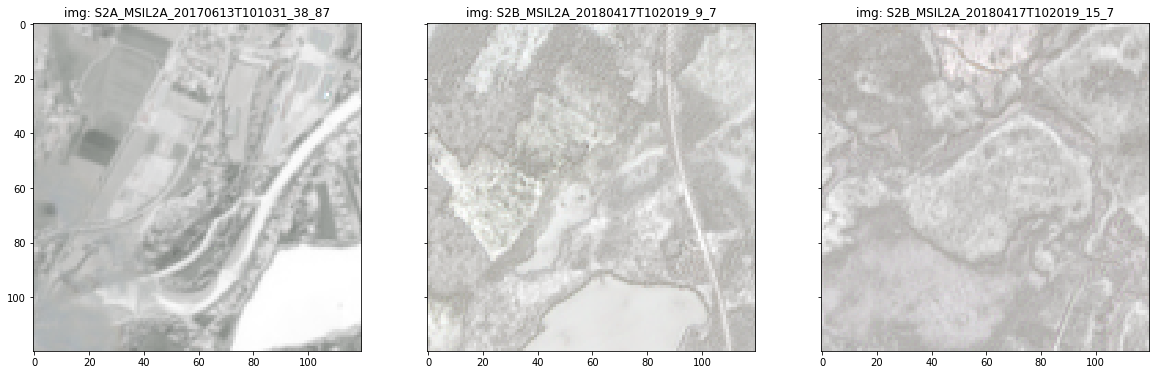

In [45]:
#pictures of snow
# Data dir
data_dir = "../bigearthnet/TOBEDELETED"
image_folderList=["S2A_MSIL2A_20170613T101031_38_87","S2B_MSIL2A_20180417T102019_9_7","S2B_MSIL2A_20180417T102019_15_7"]
visualizeGeoData(data_dir,image_folderList)

### Picture of Cloud and Shadow

0 S2A_MSIL2A_20170613T101031_75_69
1 S2B_MSIL2A_20180509T092029_1_21
2 S2A_MSIL2A_20170701T093031_2_87


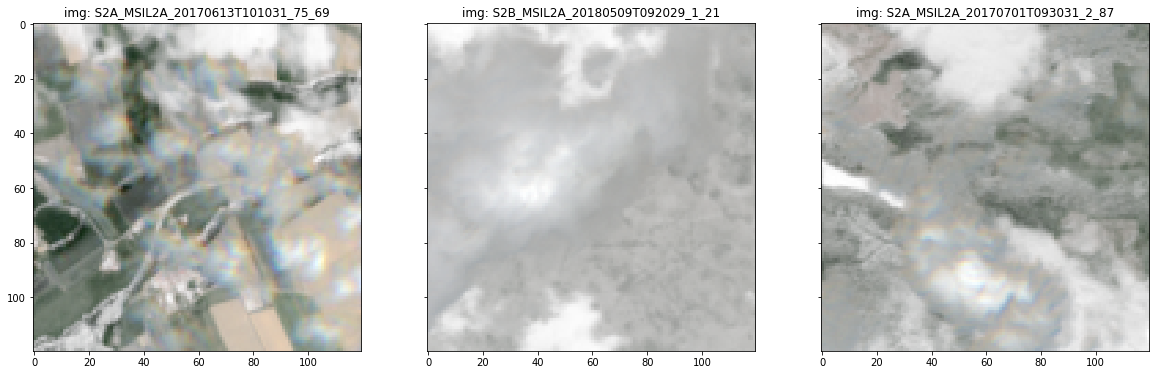

In [46]:
#pictures of cloud and shadow
# Data dir
data_dir = "../bigearthnet/TOBEDELETED"
image_folderList=["S2A_MSIL2A_20170613T101031_75_69","S2B_MSIL2A_20180509T092029_1_21","S2A_MSIL2A_20170701T093031_2_87"]
visualizeGeoData(data_dir,image_folderList)

We will have 5 broader classification now : 

    1. **Artificial Surfaces**
        - Continuous urban fabric,Discontinuous urban fabric,Industrial or commercial units,Road and rail networks and associated land,Port areas,Airports, Mineral extraction sites,Dump sites,Construction sites,Green urban areas,Sport and leisure facilities
    2. **Agricultural areas**
        - Non-irrigated arable land, Permanently irrigated land,Rice fields,Vineyards,Fruit trees and berry plantations, Olive groves,Pastures,Annual crops associated with permanent crops,Complex cultivation patterns,Land principally occupied by agriculture, with significant areas of natural vegetation,Agro-forestry areas
    3. **Forest and seminatural areas**
        - Broad-leaved forest,Coniferous forest,Mixed forest,Natural grassland,Moors and heathland,Sclerophyllous vegetation,Transitional woodland/shrub,Beaches, dunes, sands,Bare rock,Sparsely vegetated areas,Burnt areas,Glaciers and perpetual snow
    4. **Wetlands**
        - Inland marshes,Peatbogs,Salt marshes,Salines,Intertidal flats
    5. **Water bodies**
        - Combines Coastal lagoons,Estuaries,Sea and ocean,Water courses,Water bodies

### Picture of Summer Images

0 S2A_MSIL2A_20170704T112111_16_55
1 S2B_MSIL2A_20170709T094029_84_33
2 S2B_MSIL2A_20170709T094029_84_26
0 S2A_MSIL2A_20170613T101031_27_90
1 S2A_MSIL2A_20170613T101031_0_47
2 S2A_MSIL2A_20170613T101031_5_69


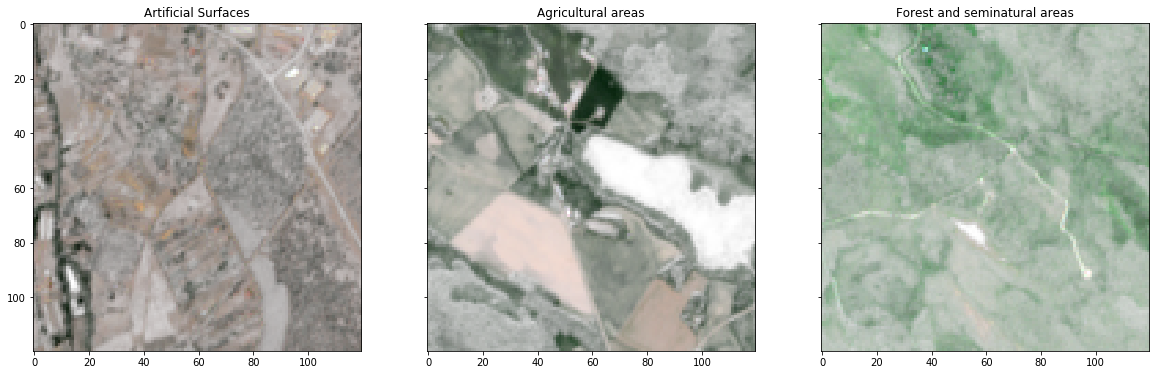

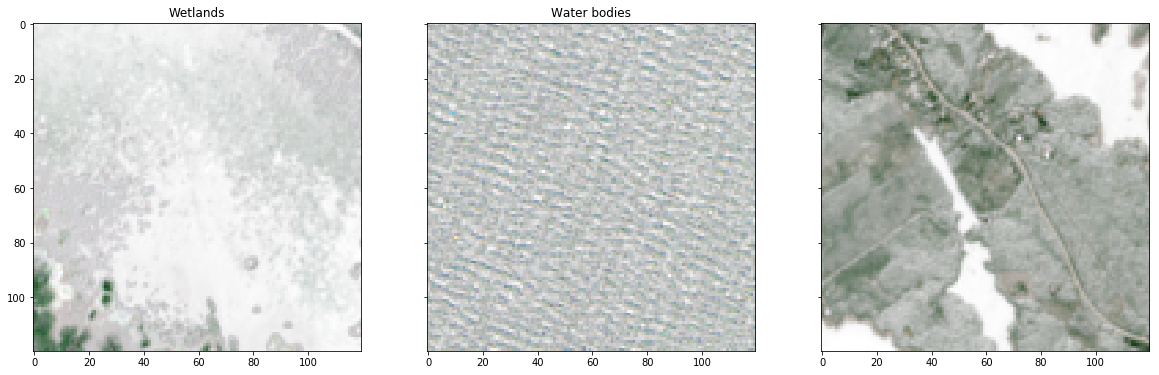

In [56]:
#pictures of Summer Images
#1. S2A_MSIL2A_20170704T112111_16_55
#2. S2B_MSIL2A_20170709T094029_84_33
#3. S2B_MSIL2A_20170709T094029_84_26
#4. S2A_MSIL2A_20170613T101031_27_90
#5. S2A_MSIL2A_20170613T101031_0_47
# Data dir
titles=["Artificial Surfaces","Agricultural areas","Forest and seminatural areas"]
data_dir = "../bigearthnet/BigEarthNet-v1.0"
image_folderList=["S2A_MSIL2A_20170704T112111_16_55","S2B_MSIL2A_20170709T094029_84_33","S2B_MSIL2A_20170709T094029_84_26"]
visualizeGeoData(data_dir,image_folderList,titles)
titles=["Wetlands","Water bodies",""]
data_dir = "../bigearthnet/BigEarthNet-v1.0"
image_folderList=["S2A_MSIL2A_20170613T101031_27_90","S2A_MSIL2A_20170613T101031_0_47","S2A_MSIL2A_20170613T101031_5_69"]
visualizeGeoData(data_dir,image_folderList,titles)

### Picture of Winter Images

0 S2B_MSIL2A_20171219T095409_10_30
1 S2A_MSIL2A_20171221T112501_85_48
2 S2A_MSIL2A_20171221T112501_85_24
0 S2A_MSIL2A_20171121T112351_56_10
1 S2A_MSIL2A_20170613T101031_0_47
2 S2A_MSIL2A_20170613T101031_5_69


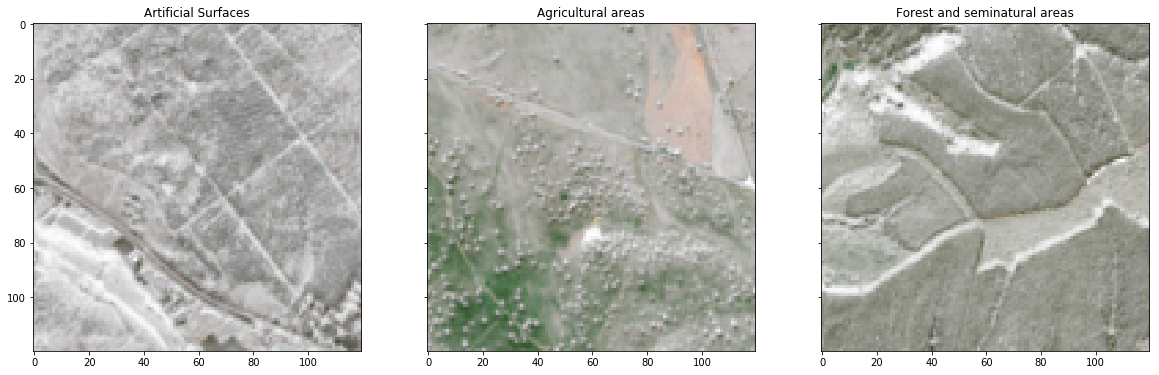

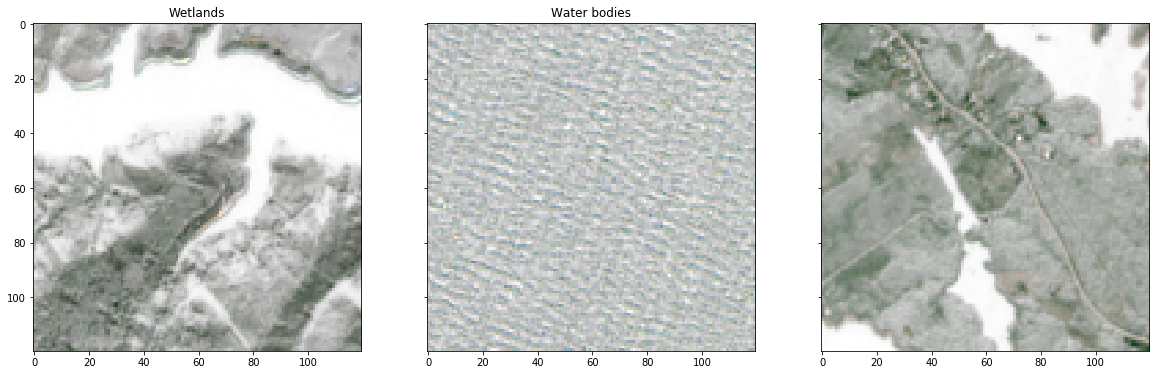

In [60]:
#pictures of Winter Images
#1. S2B_MSIL2A_20171219T095409_10_30
#2. S2A_MSIL2A_20171221T112501_85_41
#3. S2A_MSIL2A_20171221T112501_85_24
#4. 
#5.

# Data dir
data_dir = "../bigearthnet/BigEarthNet-v1.0"
titles=["Artificial Surfaces","Agricultural areas","Forest and seminatural areas"]
image_folderList=["S2B_MSIL2A_20171219T095409_10_30","S2A_MSIL2A_20171221T112501_85_48","S2A_MSIL2A_20171221T112501_85_24"]
visualizeGeoData(data_dir,image_folderList,titles)
titles=["Wetlands","Water bodies",""]
data_dir = "../bigearthnet/BigEarthNet-v1.0"
image_folderList=["S2A_MSIL2A_20171121T112351_56_10","S2A_MSIL2A_20170613T101031_0_47","S2A_MSIL2A_20170613T101031_5_69"]
visualizeGeoData(data_dir,image_folderList,titles)